In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import style
from IPython.display import Audio, display

from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

pd.options.mode.chained_assignment = None   # turn off warnings

style.use('ggplot')

# === output folder
newpath = r'./output/'
if os.path.exists(newpath):
    shutil.rmtree(newpath, ignore_errors=True)
os.makedirs(newpath)

## get delay data from .csv

In [2]:
# df69 = pd.read_csv(r'./delay_data/df_69.csv')
df = pd.read_csv(r'./delay_data/df.csv')

# df69['time'] = pd.to_datetime(df69['time'])
df['time'] = pd.to_datetime(df['time'])

col = df.shape[1]
row = df.shape[0]
print('cleaned data rows: %d' % row)
print('cleaned data cols: %d' % col)

# col = df69.shape[1]
# row = df69.shape[0]
# print('cleaned 69 data rows: %d' % row)
# print('cleaned 69 data cols: %d' % col)
# print(df69.dtypes)

cleaned data rows: 13890687
cleaned data cols: 6


## get weather data from .csv

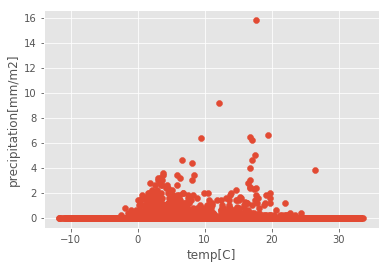

In [3]:
# === input folder
path = r'./weather/*.csv'
# === import csv as dataframe
new_cols = ['weather']
we = pd.read_csv('./weather/agrometeo-data.csv', encoding='Latin-1', header=None, names=new_cols)
wet1 = pd.DataFrame(data=we)
# === clean-up
wet = wet1.iloc[3:]
wet.loc[:, 'time'] = wet.weather.str.split(';').str.get(0)
wet.loc[:, 'temp'] = wet.weather.str.split(';').str.get(1)
wet.loc[:, 'rain'] = wet.weather.str.split(';').str.get(2)
wet.drop(wet.columns[[0]], axis=1, inplace=True)
wet.loc[:, 'time'] = pd.to_datetime(wet.loc[:, 'time'])
wet.loc[:, 'rain'] = wet.loc[:, 'rain'].apply(pd.to_numeric, errors='coerce')
wet['temp'] = wet['temp'].astype(float)
wet = wet.dropna(how='any')

# === 2D temp and rain
x = wet['temp']
y = wet['rain']
plt.scatter(x, y)
plt.title("")
plt.xlabel("temp[C]")
plt.ylabel("precipitation[mm/m2]")
plt.savefig('./output/raintemp.png', format='png', dpi=800)

# # === check size
# q = wet.shape[1]
# o = wet.shape[0]
# print('weather data rows: %d' % o)
# print('weather data columns: %d' % q)
# # print(wet.head(3))
# # print(wet.dtypes)

## merge delay and weather

In [4]:
# === inner merge on both time col which are in datetime format
# === choose between df and df69!!!
merge = df.merge(wet, left_on='time', right_on='time', how='inner')

# === check size  
q = merge.shape[1]
o = merge.shape[0]
print('merge data rows: %d' % o)
print('merge data columns: %d' % q)
print(merge.head())
print(merge.dtypes)

# # === 2D temp and rain
# x = merge['rain']
# y = merge['diff']
# plt.scatter(x, y)
# plt.title("")
# plt.xlabel("precipitation[mm/m2]")
# plt.ylabel("delay[min]")
# plt.savefig('./output/raintemp.png', format='png', dpi=800)

merge data rows: 10777724
merge data columns: 8
   linie  richtung                time      diff  weekday  hour  temp  rain
0      2         1 2018-04-01 05:00:00 -0.383333        6     5   4.1   0.0
1      2         1 2018-04-01 05:00:00  0.400000        6     5   4.1   0.0
2      2         1 2018-04-01 05:00:00 -0.433333        6     5   4.1   0.0
3      2         1 2018-04-01 05:00:00 -0.450000        6     5   4.1   0.0
4      2         1 2018-04-01 05:00:00 -0.233333        6     5   4.1   0.0
linie                int64
richtung             int64
time        datetime64[ns]
diff               float64
weekday              int64
hour                 int64
temp               float64
rain               float64
dtype: object


## smooth out data

In [5]:
smooth = merge.copy()
# smooth = smooth.set_index('time')
diffmean = smooth.groupby('time').diff.mean().to_frame()
rainmean = smooth.groupby('time').rain.mean().to_frame()
weekday = smooth.groupby('time').weekday.mean().to_frame()
hour = smooth.groupby('time').hour.mean().to_frame()
tempmean = smooth.groupby('time').temp.mean().to_frame()

smooth = diffmean.merge(rainmean, left_index=True, right_index=True, how='left')
smooth = smooth.merge(weekday, left_index=True, right_index=True, how='left')
smooth = smooth.merge(hour, left_index=True, right_index=True, how='left')
smooth = smooth.merge(tempmean, left_index=True, right_index=True, how='left')
smooth = smooth.reset_index()


# === Changes in dataset
# smooth = smooth[smooth['diff'] > 0]    # only positive delays
# smooth = smooth[smooth['temp'] > 0]
# smooth['diff'] = smooth['diff']*60    # seconds delay
# smooth = smooth[smooth['diff'] > 120]    # focus on extreme delays
# smooth['diff'] = smooth['diff'].astype('int')
# smooth['temp'] = smooth['temp'].astype('int')
# smooth['rain'] = smooth['rain']*10     # from mm/m2 to (mm/m2)/10
# smooth['rain'] = smooth['rain'].astype('int')

q = smooth['diff'].quantile(0.99)
print(q)
smooth = smooth[smooth['diff'] <= q]
smooth = smooth[smooth['diff'] >= -q]
smooth = smooth.dropna(how='any')

smooth['temp'] = smooth['temp'].round(decimals=2)
smooth['rain'] = smooth['rain'].round(decimals=2)

dataframe = smooth
array = dataframe.values

1.9917131209676904


# Weekday polynomial representation

[time(0), diff(1), rain(2), weekday(3), hour(4), temp(5)]
Best degree 4 with RMSE 1.532338628326839e-13


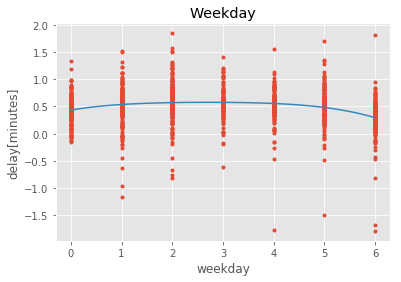

In [6]:
print('[time(0), diff(1), rain(2), weekday(3), hour(4), temp(5)]')
X = array[:,[3]]
y = X**4 + X**3 + X + 1

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

rmses = []
degrees = np.arange(1, 10)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

x = smooth['weekday']
y = smooth['diff']

z = np.polyfit(x, y, min_deg)
p = np.poly1d(z)

xp = np.linspace(0, 6, 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-')
plt.title("Weekday")
plt.xlabel("weekday")
plt.ylabel("delay[minutes]")
plt.savefig('./output/weekday_poly.png', format='png', dpi=2000)
plt.show()


# plt.plot(smooth['weekday'], smooth['diff'], '.')
# plt.plot(smooth['weekday'], slope*smooth['weekday'] + intercept, '-')
# plt.xlabel("weekday")
# plt.ylabel("delay[seconds]")
# plt.savefig('./output/weekday_delayLinReg.png', format='png', dpi=800)
# plt.show()

## hour polynomial representation

[time(0), diff(1), rain(2), weekday(3), hour(4), temp(5)]
Best degree 5 with RMSE 3.581792350902248e-11


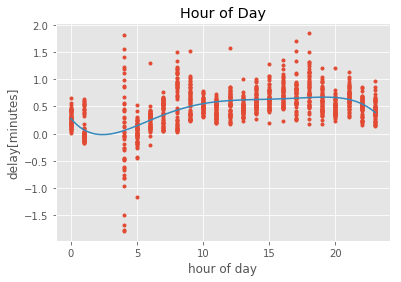

In [7]:
print('[time(0), diff(1), rain(2), weekday(3), hour(4), temp(5)]')

X = array[:,[4]]
y = X**4 + X**3 + X + 1

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

rmses = []
degrees = np.arange(1, 30)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

x = smooth['hour']
y = smooth['diff']

z = np.polyfit(x, y, min_deg)
p = np.poly1d(z)

xp = np.linspace(0, 23, 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-')
plt.title("Hour of Day")
plt.xlabel("hour of day")
plt.ylabel("delay[minutes]")
plt.savefig('./output/hour_poly.png', format='png', dpi=2000)
plt.show()

## Linear regressions

correlation temp-delay:  [[1.         0.11516069]
 [0.11516069 1.        ]]
r-squared value between temperature and delay: 0.013261984378667203


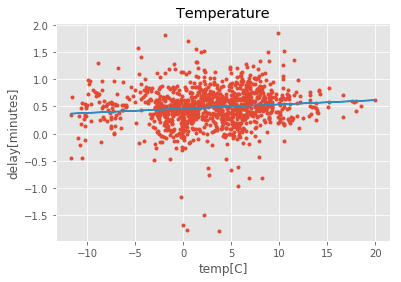

correlation rain-delay:  [[1.         0.14552593]
 [0.14552593 1.        ]]
slope, intercept, r_value, p_value, std_err : 0.06588302875992968 0.5046108909464737 0.14552593016058335 0.06808668077643339 0.03586103166669395
r-squared value between rain and delay: 0.02117779634910298


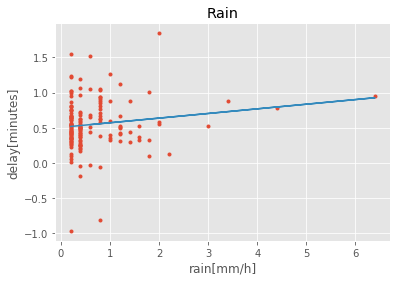

In [8]:
# === temp
print('correlation temp-delay: ', np.corrcoef(smooth.loc[:, 'temp'], smooth.loc[:, 'diff']))
slope, intercept, r_value, p_value, std_err = stats.linregress(smooth.loc[:, 'temp'], smooth.loc[:, 'diff'])
print("r-squared value between temperature and delay:", r_value ** 2)

plt.plot(smooth['temp'], smooth['diff'], '.')
plt.plot(smooth['temp'], slope*smooth['temp'] + intercept, '-')
plt.title("Temperature")
plt.xlabel("temp[C]")
plt.ylabel("delay[minutes]")
plt.savefig('./output/temp_lin.png', format='png', dpi=2000)
plt.show()

scurr = smooth[smooth['rain'] > 0]    # only rainevents
# === rain
print('correlation rain-delay: ', np.corrcoef(scurr['rain'], scurr['diff']))
slope, intercept, r_value, p_value, std_err = stats.linregress(scurr.loc[:, 'rain'], scurr.loc[:, 'diff'])
print('slope, intercept, r_value, p_value, std_err :', slope, intercept, r_value, p_value, std_err)
print("r-squared value between rain and delay:", r_value ** 2)
plt.plot(scurr['rain'], scurr['diff'], '.')
plt.plot(scurr['rain'], slope*scurr['rain'] + intercept, '-')
plt.title("Rain")
plt.xlabel("rain[mm/h]")
plt.ylabel("delay[minutes]")
plt.savefig('./output/rain_lin.png', format='png', dpi=2000)
plt.show()


# x1 = X_train[:,1].astype(int)
# x2 = X_test[:,1].astype(int)

## preprocessing

In [10]:
print('[time(0), diff(1), rain(2), weekday(3), hour(4), temp(5)]')

scurr['diff'] = scurr['diff']*60    # seconds delay
dataframe = scurr
array = dataframe.values

X = array[:,[2,3,4,5]]
Y = array[:,[1]].astype('int')
Y = Y.ravel()

test_size = 0.33
seed = 42
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

# sorted_index = np.argsort(X_test)
# X_test = X_test[sorted_index]
# Y_test = Y_test[sorted_index]

[time(0), diff(1), rain(2), weekday(3), hour(4), temp(5)]


## Automatic Feature Extraction

In [11]:
print('features: rain(0), weekday(1), hour(2), temp(3)')
# # === chi2 feature extraction  # not possible with negative values
# test = SelectKBest(score_func=chi2, k=4)
# fit = test.fit(X_train, Y_train)
# # summarize scores
# np.set_printoptions(precision=3)
# print('chi2 scores: ', fit.scores_)
# features = fit.transform(X)
# # summarize selected features
# print('chi2 features: ',features[0:5,:])

# === ExtraTreesClassifier feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print('ExtraTreesClassifier feature importance: ', model.feature_importances_)

# === PCA
features = ['rain','weekday', 'hour', 'temp']
# Separating out the features
x = smooth.loc[:, features].values
# Separating out the target
y = smooth.loc[:,['diff']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

# feature extraction
pca = PCA(n_components=2)
fit = pca.fit(x)
# summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)
print('PCA components: ', fit.components_)

features: rain(0), weekday(1), hour(2), temp(3)
ExtraTreesClassifier feature importance:  [0.18381942 0.13340479 0.33227735 0.35049844]
Explained Variance:  [0.30100771 0.26219524]
PCA components:  [[ 0.44710687  0.26395898  0.51523271  0.68187708]
 [ 0.53891146 -0.81323361  0.15493684 -0.15562809]]


## Selected Features

In [13]:
print('[time(0), diff(1), rain(2), weekday(3), hour(4), temp(5)]')

dataframe = scurr
array = dataframe.values
X = array[:,[2,3,4,5]]
Y = array[:,[1]].astype('int')
Y = Y.ravel()

test_size = 0.33
seed = 42
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

[time(0), diff(1), rain(2), weekday(3), hour(4), temp(5)]


## LogisticRegression

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X, Y)

scores = cross_val_score(model, X, Y, scoring='neg_mean_squared_error')
print('neg_mean_squared_error: ', scores.mean())

# # save the model to disk
# filename = 'first_prediction.sav'
# pickle.dump(model, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

pred = model.predict(X_test)
print('features: [rain, weekday, hour, temp]')
for i in range(10):
    print("X=%s, Predicted=%s" % (X_test[i] , Y_test[i]))

neg_mean_squared_error:  -374.4123376623377
features: [rain, weekday, hour, temp]
X=[0.4 5 10 4.7], Predicted=28
X=[0.4 0 13 1.3], Predicted=18
X=[0.2 6 14 10.9], Predicted=16
X=[0.2 2 20 8.6], Predicted=26
X=[0.2 1 23 6.0], Predicted=32
X=[0.2 0 13 7.9], Predicted=25
X=[0.2 2 8 7.8], Predicted=61
X=[0.8 2 13 10.4], Predicted=39
X=[1.0 2 7 7.3], Predicted=36
X=[0.6 0 13 3.6], Predicted=26


/Users/emanuel/Documents/Coding/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


## Multi-Layer Perceptron

In [18]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=1,
                    max_iter=300, shuffle=True, momentum=0.8, epsilon=1e-08, verbose=True, early_stopping=True)
clf.fit(X_train, Y_train)

scores = cross_val_score(model, X_train, Y_train, scoring='neg_mean_squared_error')
print('neg_mean_squared_error:', scores.mean())

pred = model.predict(X_test)
print('[weekday, hour]')
for i in range(10):
    print("X=%s, Predicted=%s" % (X_test[i], Y_test[i]))

display(Audio("./weather/ape.mp3", autoplay=True))

Iteration 1, loss = 4.03514584
Validation score: 0.000000
Iteration 2, loss = 4.03361840
Validation score: 0.000000
Iteration 3, loss = 4.03215428
Validation score: 0.000000
Iteration 4, loss = 4.03074820
Validation score: 0.000000
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
neg_mean_squared_error: -356.11507936507945
[weekday, hour]
X=[0.4 5 10 4.7], Predicted=28
X=[0.4 0 13 1.3], Predicted=18
X=[0.2 6 14 10.9], Predicted=16
X=[0.2 2 20 8.6], Predicted=26
X=[0.2 1 23 6.0], Predicted=32
X=[0.2 0 13 7.9], Predicted=25
X=[0.2 2 8 7.8], Predicted=61
X=[0.8 2 13 10.4], Predicted=39
X=[1.0 2 7 7.3], Predicted=36
X=[0.6 0 13 3.6], Predicted=26


/Users/emanuel/Documents/Coding/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


## visualize, analyse data

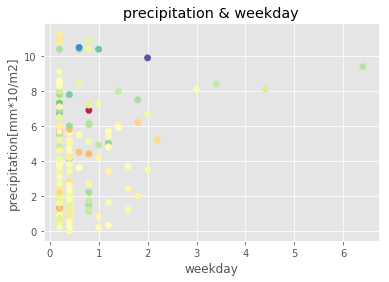

count    1193.000000
mean        0.085163
std         0.357174
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.400000
Name: rain, dtype: float64
count    1193.000000
mean        0.480900
std         0.350520
min        -1.783333
25%         0.311731
50%         0.494717
75%         0.666941
max         1.842574
Name: diff, dtype: float64
r-squared value between rain and delay: 0.007585743923448577


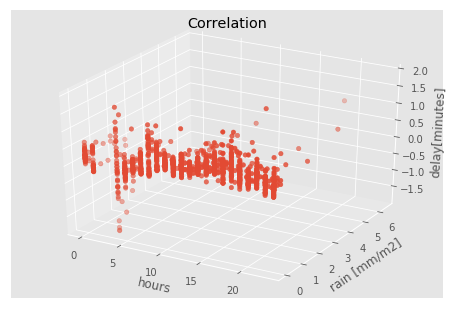

In [19]:
from mpl_toolkits.mplot3d import Axes3D

style.use("ggplot")

# show input features
plt.scatter(X[:, 0], X[:, 3], s=40, c=Y, cmap=plt.cm.Spectral)
plt.xlabel('weekday')
plt.ylabel('precipitation[mm*10/m2]')
plt.title('precipitation & weekday')
plt.savefig('./output/weekdays&rain.png', format='png', dpi=800)
plt.show()

month = scurr.copy()
day = scurr.copy()
hour = smooth.copy()

month['time'] = month.loc[:, 'time'].apply(lambda x: x.month)
day['time'] = day.loc[:, 'time'].apply(lambda x: x.day)
hour['time'] = hour.loc[:, 'time'].apply(lambda x: x.hour)

# # === 2D monthly distribution of delays
# x = month.loc[:, 'time']
# y = month.loc[:, 'diff']
# plt.scatter(x, y)
# plt.title("monthly distribution")
# plt.xlabel("months")
# plt.ylabel("delay[minutes]")
# plt.savefig('./output/2Dmonthly.png', format='png', dpi=800)
# # plt.show()

# # === 2D daily distribution of delays
# x = day.loc[:, 'weekday']
# y = day.loc[:, 'diff']
# plt.scatter(x, y)
# plt.title("daily distribution")
# plt.xlabel("weekday")
# plt.ylabel("delay[minutes]")
# plt.savefig('./output/2Ddaily.png', format='png', dpi=800)
# # plt.show()

# # === 2D hourly distribution of delays
# x = hour.loc[:, 'time']
# y = hour.loc[:, 'diff']
# plt.scatter(x, y)
# plt.title("hourly distribution")
# plt.xlabel("hours")
# plt.ylabel("delay[minutes]")
# plt.savefig('./output/2Dhourly.png', format='png', dpi=800)
# # plt.show()

# # === 2D dependency on rain
# x = smooth.loc[:, 'rain']
# y = smooth.loc[:, 'diff']
# plt.scatter(x, y)
# plt.title("correlation")
# plt.xlabel("rain[mm/m2]")
# plt.ylabel("delay[minutes]")
# plt.savefig('./output/2Drain-delay.png', format='png', dpi=800)
# # plt.show()

# === 3D Figure rain, time, delay
x = hour.loc[:, 'time']
y = hour.loc[:, 'rain']
z = hour.loc[:, 'diff']
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)
plt.title("Correlation")
ax.set_xlabel('hours')
ax.set_ylabel('rain [mm/m2]')
ax.set_zlabel('delay[minutes]')
plt.savefig('./output/3DcorrelationHourly.png', format='png', dpi=800)
# plt.show()

# === other statistics on data

print(smooth.loc[:,'rain'].describe())
print(smooth.loc[:,'diff'].describe())

slope, intercept, r_value, p_value, std_err = stats.linregress(smooth.loc[:, 'rain'], smooth.loc[:, 'diff'])
print("r-squared value between rain and delay:", r_value ** 2)

display(Audio("./weather/ape.mp3", autoplay=True))